In [1]:

## ON laptop, use python 3.11
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='Blues')
from slmsuite.holography.algorithms import Hologram
from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.cameras.camera import Camera
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import SpotHologram
from slmsuite.holography import analysis
import copy
from IPython.display import Image
import imageio
import cv2
import numpy as np
import ctypes
from ctypes import *
from scipy import misc
from time import sleep 
import csv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# from instrumental.drivers.cameras import uc480 

from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *
from slmfunctions.slmsuite.slmsuite.holography.analysis import *

from scipy.optimize import curve_fit


# TURN ON FOR EXPERIMENT

# from slmfunctions.slmsuite.slmsuite.hardware.slms.meadowlark import Meadowlark
# # Meadowlark.info(verbose = True)
# from slmfunctions.slmsuite.slmsuite.hardware.cameras.thorlabs import ThorCam
# ThorCam.info(verbose=True)
# from slmfunctions.slmsuite.slmsuite.hardware.cameraslms import FourierSLM

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920



cupy not installed. Using numpy.
cupy not installed. Using numpy.
cupy not installed. Using numpy.


In [15]:
imgname = f"10by10_9spacing_mag3grid" # LOOKUP NAME
load_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage'  # For PC
# load_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS-Summer2024\storage' # For laptop

# Local laptop stroage
load_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage'

optimizedout_tweezer = load_from_file(load_dir, f'tweezers{imgname}')
optimizedout_anchors = load_from_file(load_dir, f'anchors{imgname}')

Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\tweezers10by10_9spacing_mag3grid.pkl
Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\anchors10by10_9spacing_mag3grid.pkl


In [3]:
from slmfunctions.slmsuite.slmsuite.hardware.slms.meadowlark import Meadowlark
slm = Meadowlark(sdk_path="C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI", 
                 lut_path=r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS-Summer2024\initslm\globalcalibrationat650_june2024.lut')
                #  lut_path=r'C:\Program Files\Meadowlark Optics\Blink 1920 HDMI\LUT Files\slm1_at650good.lut'))
# slm.load_vendor_phase_correction(
#     file_path=r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\MeadowLark SLM\SLM\slm6287_at785_WFC.jpg',  # Update this path to load your calibration
# )

Validating DPI awareness...success
Constructing Blink SDK...success
Loading LUT file...

In [4]:
from slmfunctions.slmsuite.slmsuite.hardware.cameras.thorlabs import ThorCam
ThorCam.info(verbose=True)
cam = ThorCam()

ThorCam serials:
"19001"
TLCameraSDK initializing... success
Looking for cameras... success
ThorCam sn "19001" initializing... success


In [5]:
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration(file_path = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS_Summer2024\initslm\19001-Meadowlark-wavefront-calibration_00006.h5')

'C:\\cleen\\nsong\\2-Research\\UAC Research\\Github\\Ultracold-Research\\GWS_Summer2024\\initslm\\19001-Meadowlark-wavefront-calibration_00006.h5'

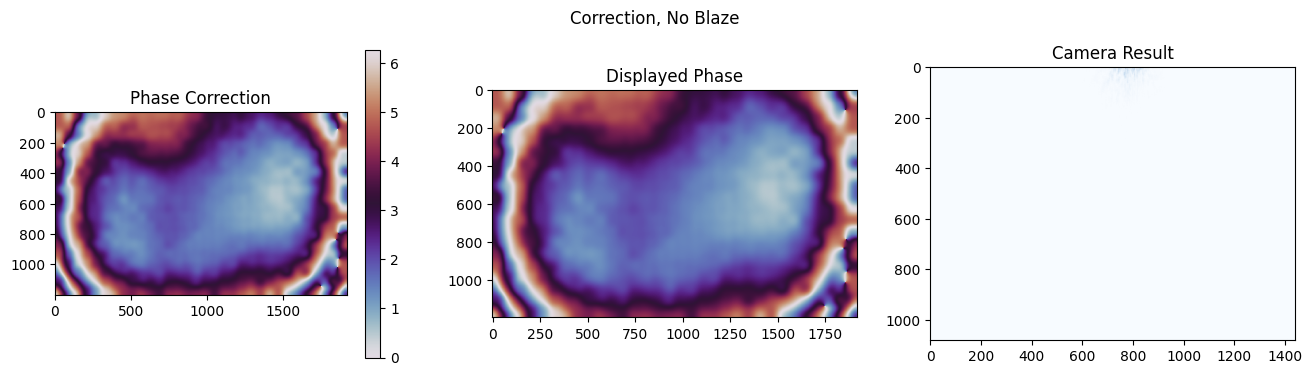

In [6]:
slm.write(None, settle=True)
def plot(title=""):
    _, axs = plt.subplots(1, 3, figsize=(16,4))

    if slm.phase_correction is None:
        correction = 0 * slm.phase
    else:
        correction = np.mod(slm.phase_correction, 2*np.pi)

    axs[0].set_title("Phase Correction")
    im0 = axs[0].imshow(
        correction,
        vmin=0,
        vmax=2*np.pi,
        interpolation="none",
        cmap="twilight"
    )
    plt.colorbar(im0, ax=axs[0], orientation='vertical')

    axs[1].set_title("Displayed Phase")
    axs[1].imshow(
        np.mod(slm.phase, 2*np.pi),
        vmin=0,
        vmax=2*np.pi,
        interpolation="none",
        cmap="twilight"
    )

    axs[2].set_title("Camera Result")
    axs[2].imshow(cam.get_image())

    plt.suptitle(title)
    plt.show()
plot(title="Correction, No Blaze")


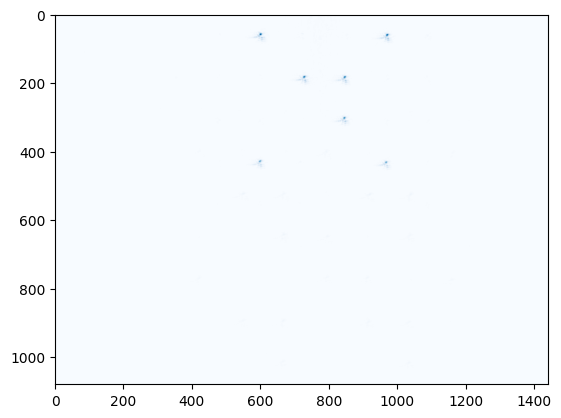

In [28]:
plt.imshow(cam.get_image())

In [27]:
# First, check the alignment of the tweezers. Manually detect flips / rotations and correct for them:
rotateby90, fliphorizontal, flipvertical = 1, False, False # Adjust until matched
exposure = 0.01
N = 35
angle, alignedanchors, empty_tweezerregions, empty_tweezercenters = Exp_configureanchors(cam, slm, optimizedout_tweezer, optimizedout_anchors, exposure, N, rotateby90, fliphorizontal, flipvertical)
plot_arrays([zoomin((optimizedout_anchors.get_uniformtarget())), alignedanchors])
plot_tweezerregions(alignedanchors, empty_tweezerregions, empty_tweezercenters, figsize=(7,7))

AxisError: axis 1 is out of bounds for array of dimension 1

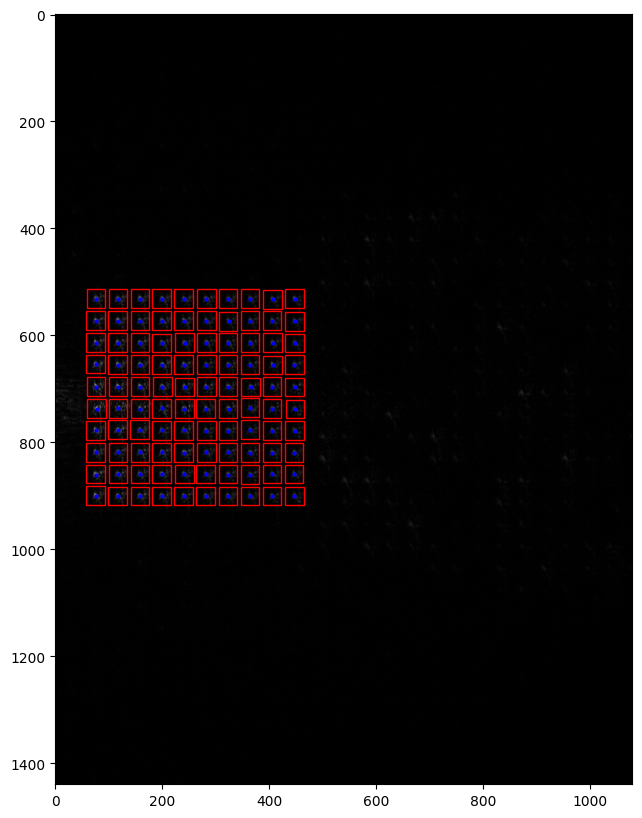

In [12]:
# Now take an image to make sure tweezers are being identified and mapped properly
exposure_tweezers = 0.003
scalingfactor = 4
retrievemax = True # Determines if you only want the max camera value (False) or do a Gaussian fit (True)
BloborDelta = 'Delta' # When mapping the camera image to the target array, do you map the whole thing or just the max value?

mappedblobs, tweezerstatistics, cameradata = Exp_cameratoarray(cam, slm, optimizedout_tweezer, optimizedout_anchors, angle, empty_tweezercenters, exposure_tweezers, N, scalingfactor, retrievemax, BloborDelta, rotateby90, fliphorizontal, flipvertical)
goodnessoffit, tweezerpower, tweezers_hordist, tweezers_vertdist = tweezerstatistics
refinedcamimage_tweezer, refined_tweezercenters = cameradata
plot_tweezerregions(refinedcamimage_tweezer, empty_tweezerregions, refined_tweezercenters)

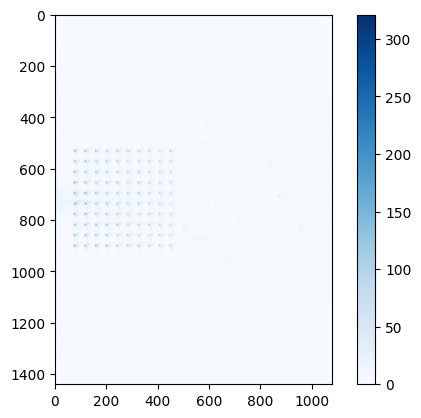

In [14]:
plt.imshow(refinedcamimage_tweezer)
plt.colorbar()

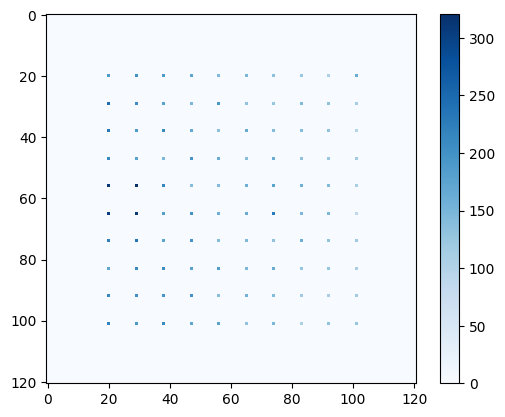

In [15]:
plt.imshow(zoomin(mappedblobs))
plt.colorbar()

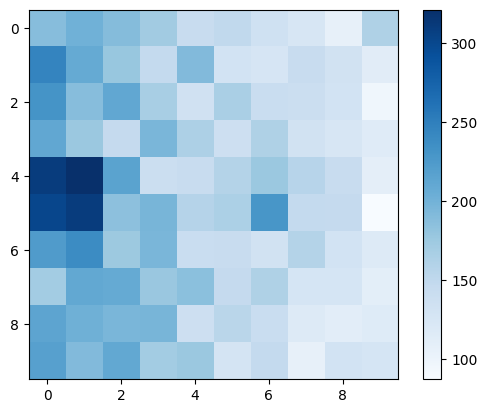

In [16]:
plt.imshow(tweezerpower)
plt.colorbar()

In [17]:
optimizedout_tweezer.set_beam(None)
metrics, cameradata_last, tweezerGWSs, cameraout = camerafeedback_tweezers(cam, slm, optimizedout_tweezer, optimizedout_anchors, angle, empty_tweezercenters, exposure_tweezers, Exp_Lukin, 5, 20, N, scalingfactor, retrievemax, BloborDelta, rotateby90, fliphorizontal, flipvertical, "Constant")

0
1
Poor fit at site (5, 4)
2
Poor fit at site (4, 0)
Poor fit at site (5, 4)
3
4


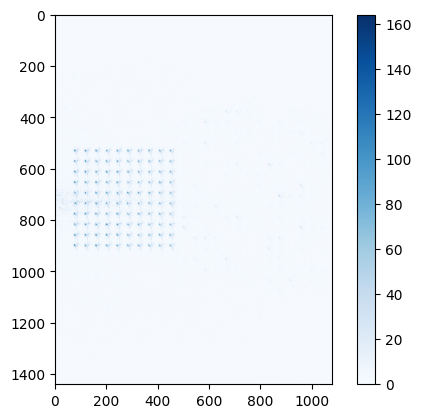

In [18]:
plt.imshow(cameradata_last[0])
plt.colorbar()

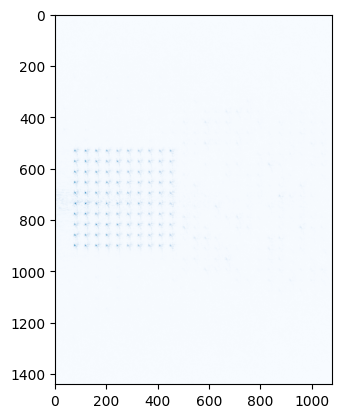

In [19]:
plt.imshow(cameraout[0][0])

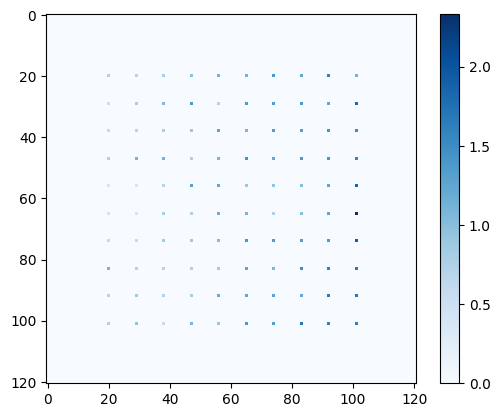

In [20]:
plt.imshow(tweezerGWSs.get_targetim()[1888:2009, 2005:2126])
plt.colorbar()

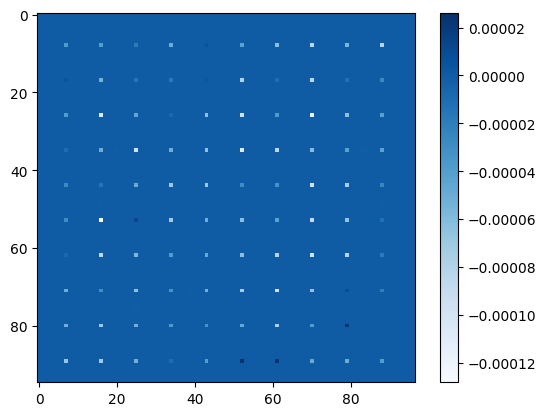

In [15]:
plt.imshow((tweezerGWSs.get_targetim() / cp.max(tweezerGWSs.get_targetim()) - tweezerGWSs.get_stdint())[1900:1995, 2018:2115])
plt.colorbar()

(array([[0., 0., 0., 0., 2., 5., 1., 0., 1., 1.],
        [0., 0., 0., 1., 6., 0., 1., 0., 0., 2.],
        [0., 0., 1., 4., 3., 2., 0., 0., 0., 0.],
        [0., 0., 3., 4., 1., 2., 0., 0., 0., 0.],
        [0., 2., 3., 5., 0., 0., 0., 0., 0., 0.],
        [0., 4., 5., 1., 0., 0., 0., 0., 0., 0.],
        [0., 3., 4., 2., 0., 1., 0., 0., 0., 0.],
        [1., 5., 4., 0., 0., 0., 0., 0., 0., 0.],
        [2., 6., 2., 0., 0., 0., 0., 0., 0., 0.],
        [7., 2., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([ 94. , 117.1, 140.2, 163.3, 186.4, 209.5, 232.6, 255.7, 278.8,
        301.9, 325. ]),
 <a list of 10 BarContainer objects>)

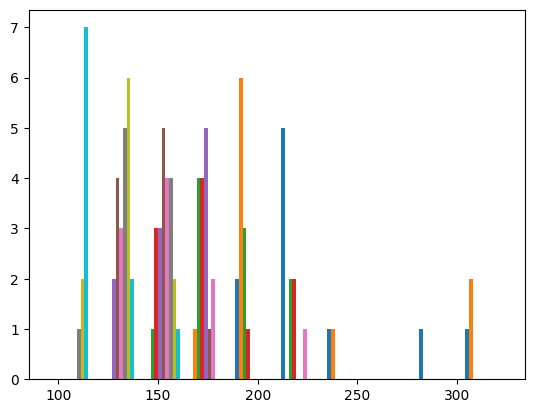

In [21]:
plt.hist(metrics[0][1])

(array([[0., 0., 0., 1., 1., 3., 2., 0., 1., 2.],
        [0., 0., 0., 2., 2., 3., 0., 0., 1., 2.],
        [0., 0., 0., 2., 2., 3., 2., 1., 0., 0.],
        [0., 1., 1., 2., 3., 3., 0., 0., 0., 0.],
        [0., 0., 4., 4., 1., 1., 0., 0., 0., 0.],
        [0., 2., 2., 3., 3., 0., 0., 0., 0., 0.],
        [0., 1., 6., 1., 1., 1., 0., 0., 0., 0.],
        [0., 2., 3., 3., 2., 0., 0., 0., 0., 0.],
        [0., 5., 4., 1., 0., 0., 0., 0., 0., 0.],
        [4., 4., 1., 1., 0., 0., 0., 0., 0., 0.]]),
 array([ 88. ,  95.6, 103.2, 110.8, 118.4, 126. , 133.6, 141.2, 148.8,
        156.4, 164. ]),
 <a list of 10 BarContainer objects>)

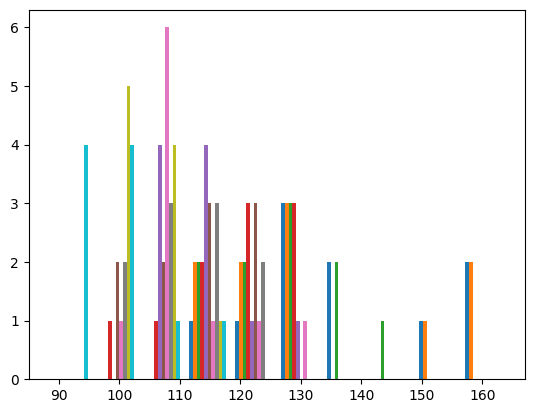

In [23]:
plt.hist(metrics[-1][1])

In [ ]:
plt.imshow(refinedcamimage_tweezer)
plt.colorbar()